In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')


### Clustering with KMeans

In [142]:
# ´Patient 1´

# /home/liubov/Bureau/new/8-5-2024_#18_INDIVIDUAL_[12]/processed by chunks/PosesDir/new_jsons_merged_id_1.json
# %run /home/liubov/Bureau/feature_extraction/analyze_joint_variance.py
joint_positions = pd.read_csv("joint_positions.csv")

# Create a mapping dictionary
patient_rename_map = {
    'Patient1': 'Patient_1',
    'Patient2': 'Therapist_1',
    'Patient3': 'Therapist_2'
}

# Apply the renaming to the 'Patient' column
joint_positions['Patient'] = joint_positions['Patient'].replace(patient_rename_map)


joint_positions_patient1 = joint_positions[joint_positions.Patient=='Patient_1']
# # Pivot to get features: one row per frame, one column per joint/coordinate
df_pivot = joint_positions_patient1.pivot_table(
    index='Frame',
    columns='Joint',
    values=['X', 'Y']
)

# # Flatten MultiIndex columns: ('X', 'LeftHip') → 'X_LeftHip'
df_pivot.columns = [f"{coord}_{joint}" for coord, joint in df_pivot.columns]
df_pivot = df_pivot.dropna()  # Remove frames with missing joints

df_pivot.head()

,X_Background,X_LAnkle,X_LBigToe,X_LEar,X_LElbow,X_LEye,X_LHeel,X_LHip,X_LKnee,X_LShoulder,...,Y_RBigToe,Y_REar,Y_RElbow,Y_REye,Y_RHeel,Y_RHip,Y_RKnee,Y_RShoulder,Y_RSmallToe,Y_RWrist
Frame,,,,,,,,,,,,,,,,,,,,,
62,446.51364,395.94577,460.27704,416.21960,423.62347,416.35920,456.22820,390.44400,447.98980,425.88098,...,197.89607,199.16190,94.596460,187.47496,157.84230,106.939644,107.61823,95.820720,151.19637,98.068886
63,447.24280,396.01770,460.73782,416.21204,423.48914,416.34390,456.88490,390.66760,448.15080,425.76130,...,197.88039,199.36084,95.014984,187.70726,158.56786,107.199326,107.85085,96.132850,152.29877,98.293980
64,447.24344,396.02680,461.97952,416.62744,423.47894,416.44350,458.33725,390.68436,448.58330,425.75363,...,197.86183,199.76929,95.143290,187.99518,158.30382,107.470140,108.26997,96.309580,151.80446,98.695076
66,450.00043,396.46722,463.06332,416.84540,423.43295,416.88837,459.54040,390.74228,449.06265,425.73196,...,198.60430,202.32072,95.055466,190.42198,158.24200,107.562096,108.57880,96.251144,150.93953,98.844574
67,450.64420,396.80057,463.44098,417.07205,423.42294,417.20706,459.99730,390.75336,449.42767,425.72100,...,199.26654,202.88990,95.176680,191.10252,158.60226,107.753180,108.82244,96.399190,151.20506,99.080060


In [143]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pivot)

# Run KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
df_pivot['Cluster'] = kmeans.fit_predict(X_scaled)

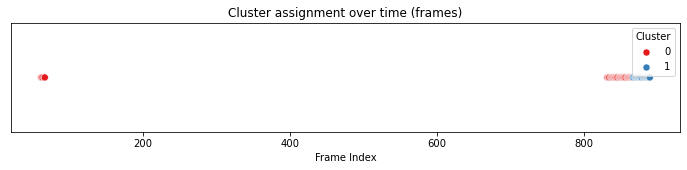

In [144]:
# Cluster assignments over time
plt.figure(figsize=(12, 2))
sns.scatterplot(x=df_pivot.index, y=[1]*len(df_pivot), hue=df_pivot['Cluster'], palette='Set1', s=50)
plt.title("Cluster assignment over time (frames)")
plt.yticks([])
plt.xlabel("Frame Index")
plt.legend(title="Cluster")
plt.show()

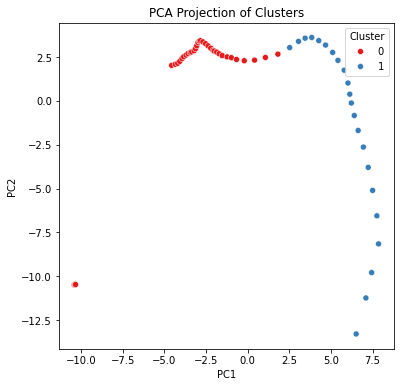

In [145]:
# PCA projection

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_pivot['Cluster'], palette='Set1')
plt.title("PCA Projection of Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [146]:
df_pivot.groupby('Cluster').mean().filter(like='Y_')

,Y_Background,Y_LAnkle,Y_LBigToe,Y_LEar,Y_LElbow,Y_LEye,Y_LHeel,Y_LHip,Y_LKnee,Y_LShoulder,...,Y_RBigToe,Y_REar,Y_RElbow,Y_REye,Y_RHeel,Y_RHip,Y_RKnee,Y_RShoulder,Y_RSmallToe,Y_RWrist
Cluster,,,,,,,,,,,,,,,,,,,,,
0,246.828086,145.480849,165.050736,175.498025,101.781110,164.350356,163.720013,112.133613,170.479326,102.92849,...,167.283663,170.469104,105.799066,168.167972,183.148648,115.693120,113.652274,105.777947,193.152794,104.001415
1,449.757729,302.385492,359.264985,340.836108,244.704958,325.779195,356.200929,258.278275,378.880847,247.49446,...,331.145796,374.150591,259.408644,366.737361,360.541066,273.392434,266.659119,257.981028,389.938200,250.125221


- Cluster 0:

Y values are smaller → body joints are higher in the image

Hips ~112, knees ~170, shoulders ~102

This suggests: person is **standing** (joints are upright, not compressed)

- Cluster 1:

Y values are larger → body joints are lower in the image

Hips ~258, knees ~378, shoulders ~247

This suggests: person is **sitting** (hips and knees are closer to the ground)

Processing patients/therapists: Patient_1


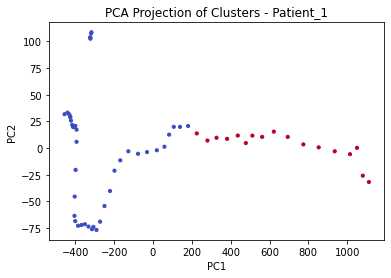

Processing patients/therapists: Therapist_1


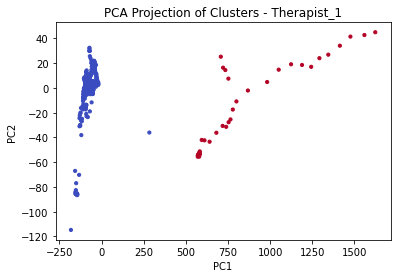

Processing patients/therapists: Therapist_2


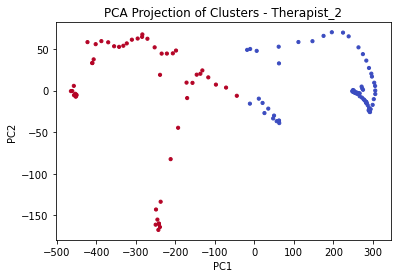

     Patient  Frame      Pose
0  Patient_1     62  Standing
1  Patient_1     63  Standing
2  Patient_1     64  Standing
3  Patient_1     66  Standing
4  Patient_1     67  Standing
Pose
Standing    525
Sitting     123
Name: count, dtype: int64


In [147]:
# Store results for all patients/therapists

all_clustered_data = []

# Loop over each patients/therapists
for patient_id in joint_positions['Patient'].unique():
    print(f"Processing patients/therapists: {patient_id}")
    
    df_patient = joint_positions[joint_positions['Patient'] == patient_id]

    # Pivot to get one row per frame with all joint Y coordinates
    df_pivot = df_patient.pivot_table(index='Frame', columns='Joint', values='Y')

    df_pivot.columns = [f"Y_{col}" for col in df_pivot.columns]
    df_pivot = df_pivot.dropna()

    if df_pivot.empty:
        print(f"  - Skipping {patient_id}, not enough data.")
        continue

    # Run PCA for visualization (optional)
    pca = PCA(n_components=2)
    pca_proj = pca.fit_transform(df_pivot)

    # Cluster with KMeans
    kmeans = KMeans(n_clusters=2, random_state=42)
    df_pivot['Cluster'] = kmeans.fit_predict(df_pivot)

    # Infer which cluster is "Sitting" vs "Standing" based on Y_Hip or mean Y
    cluster_means = df_pivot.groupby('Cluster').mean()
    standing_cluster = cluster_means.mean(axis=1).idxmin()  # Lower Y = higher = standing
    sitting_cluster = cluster_means.mean(axis=1).idxmax()

    cluster_to_pose = {
        standing_cluster: 'Standing',
        sitting_cluster: 'Sitting'
    }

    df_pivot['Pose'] = df_pivot['Cluster'].map(cluster_to_pose)
    df_pivot['Patient'] = patient_id
    df_pivot['Frame'] = df_pivot.index

    all_clustered_data.append(df_pivot.reset_index(drop=True))

    # Optional: Plot PCA
    plt.figure(figsize=(6, 4))
    plt.scatter(pca_proj[:, 0], pca_proj[:, 1], c=df_pivot['Cluster'], cmap='coolwarm', s=10)
    plt.title(f'PCA Projection of Clusters - {patient_id}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

# Concatenate all results into one DataFrame
pose_clusters_all = pd.concat(all_clustered_data, ignore_index=True)

# Preview
print(pose_clusters_all[['Patient', 'Frame', 'Pose']].head())
print(pose_clusters_all.Pose.value_counts())


In [148]:
pose_counts = pose_clusters_all.groupby(['Patient', 'Pose']).size().unstack(fill_value=0)

# Optional: Normalize to get % time spent
pose_ratios = pose_counts.div(pose_counts.sum(axis=1), axis=0) * 100

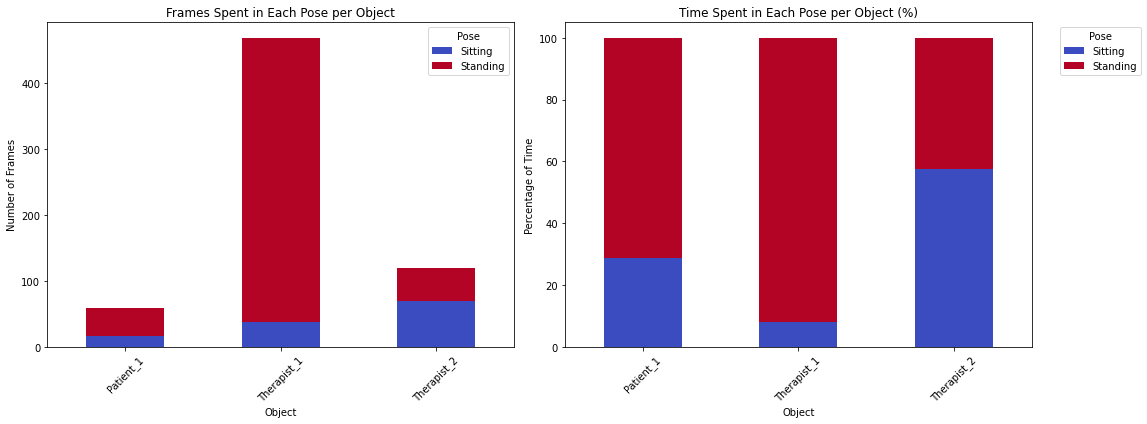

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# --- Plot 1: Raw Counts ---
pose_counts.plot(kind='bar', 
                 stacked=True, 
                 ax=axes[0], 
                 colormap='coolwarm')

axes[0].set_title('Frames Spent in Each Pose per Object')
axes[0].set_ylabel('Number of Frames')
axes[0].set_xlabel('Object')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Pose')

# --- Plot 2: Percentages ---
pose_ratios.plot(kind='bar', 
                 stacked=True, 
                 ax=axes[1], 
                 colormap='coolwarm')

axes[1].set_title('Time Spent in Each Pose per Object (%)')
axes[1].set_ylabel('Percentage of Time')
axes[1].set_xlabel('Object')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Pose', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [151]:
pose_clusters_all.columns

Index(['Y_Background', 'Y_LAnkle', 'Y_LBigToe', 'Y_LEar', 'Y_LElbow', 'Y_LEye',
       'Y_LHeel', 'Y_LHip', 'Y_LKnee', 'Y_LShoulder', 'Y_LSmallToe',
       'Y_LWrist', 'Y_MidHip', 'Y_Neck', 'Y_Nose', 'Y_RAnkle', 'Y_RBigToe',
       'Y_REar', 'Y_RElbow', 'Y_REye', 'Y_RHeel', 'Y_RHip', 'Y_RKnee',
       'Y_RShoulder', 'Y_RSmallToe', 'Y_RWrist', 'Cluster', 'Pose', 'Patient',
       'Frame'],
      dtype='object')

In [152]:
joint_positions.head()

,Patient,Joint,Frame,X,Y
0,Patient_1,Nose,5,436.66135,76.533104
1,Patient_1,Nose,6,436.66068,76.558914
2,Patient_1,Nose,7,436.50210,78.160120
3,Patient_1,Nose,8,436.44742,78.432010
4,Patient_1,Nose,9,436.44205,78.703476


In [153]:
# Merge joint_positions with cluster+pose info from pose_clusters_all
joint_positions_with_pose = joint_positions.merge(
    pose_clusters_all[['Patient', 'Frame', 'Cluster', 'Pose']],
    on=['Patient', 'Frame'],
    how='left'  # keep all rows from joint_positions
)
# print(joint_positions_with_pose.Pose.isna().sum())
# print(len(joint_positions_with_pose))

Processing patient: Patient_1


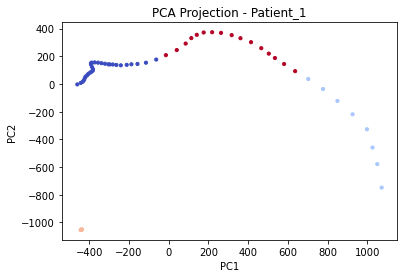

Processing patient: Therapist_1


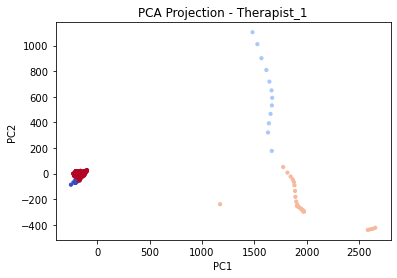

Processing patient: Therapist_2


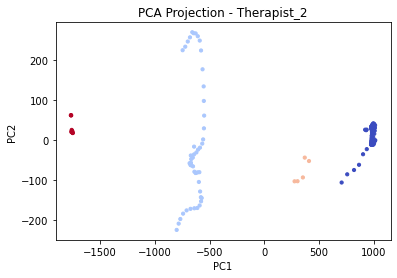

In [155]:
# Code for Multi-Class Pose Clustering

# Choose number of clusters (e.g., 3: Standing, Sitting, Lying)
N_CLUSTERS = 4

# Store all results
all_clustered_data = []

for patient_id in joint_positions['Patient'].unique():
    print(f"Processing patient: {patient_id}")
    
    df_patient = joint_positions[joint_positions['Patient'] == patient_id]

    # Pivot X and Y
    df_pivot_x = df_patient.pivot_table(index='Frame', columns='Joint', values='X')
    df_pivot_y = df_patient.pivot_table(index='Frame', columns='Joint', values='Y')

    # Combine X and Y
    df_features = pd.concat([
        df_pivot_x.add_prefix('X_'),
        df_pivot_y.add_prefix('Y_')
    ], axis=1).dropna()

    if df_features.empty:
        print(f"  - Skipping {patient_id}, not enough data.")
        continue

    # PCA projection for visualization
    pca = PCA(n_components=2)
    pca_proj = pca.fit_transform(df_features)

    # KMeans clustering
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
    df_features['Cluster'] = kmeans.fit_predict(df_features)

    # Use only Y to determine pose height (for interpretation)
    y_only = df_pivot_y.loc[df_features.index]
    y_only['Cluster'] = df_features['Cluster']
    cluster_y_means = y_only.groupby('Cluster').mean().mean(axis=1)

    # Sort clusters by Y (lower Y = higher body = standing)
    sorted_clusters = cluster_y_means.sort_values().index.tolist()

    # Map sorted clusters to poses
    sorted_clusters = cluster_y_means.sort_values().index.tolist()
    pose_names = ['Standing', 'Sitting', 'Lying', 'Unknown']
    cluster_to_pose = {cluster: pose for cluster, pose in zip(sorted_clusters, pose_names)}


    # Assign pose labels
    df_features['Pose'] = df_features['Cluster'].map(cluster_to_pose)
    df_features['Patient'] = patient_id
    df_features['Frame'] = df_features.index

    all_clustered_data.append(df_features.reset_index(drop=True))

    # Optional PCA plot
    plt.figure(figsize=(6, 4))
    plt.scatter(pca_proj[:, 0], pca_proj[:, 1], c=df_features['Cluster'], cmap='coolwarm', s=10)
    plt.title(f'PCA Projection - {patient_id}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()


In [156]:
# Combine all
pose_clusters_all = pd.concat(all_clustered_data, ignore_index=True)

# Keep columns to merge
pose_assignments = pose_clusters_all[['Patient', 'Frame', 'Pose', 'Cluster']]

# Merge
joint_positions_with_pose = joint_positions.merge(
    pose_assignments,
    on=['Patient', 'Frame'],
    how='left'
)


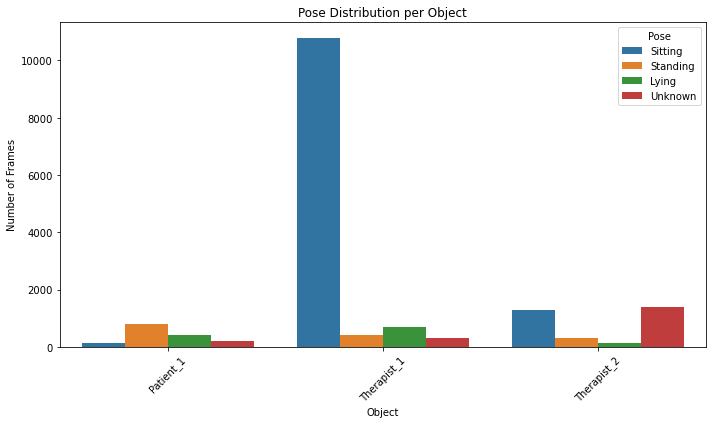

In [157]:
plt.figure(figsize=(10, 6))
sns.countplot(data=joint_positions_with_pose, x='Patient', hue='Pose')
plt.title("Pose Distribution per Object")
plt.ylabel("Number of Frames")
plt.xlabel("Object")
plt.xticks(rotation=45)
plt.legend(title='Pose')
plt.tight_layout()
plt.show()


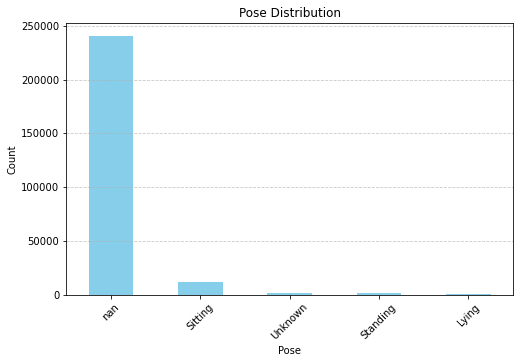

In [158]:
pose_counts = joint_positions_with_pose['Pose'].value_counts(dropna=False)

plt.figure(figsize=(8, 5))
pose_counts.plot(kind='bar', color='skyblue')
plt.title('Pose Distribution')
plt.xlabel('Pose')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Cluster to Pose Mapping:
Cluster 0 → Pose: Standing
Cluster 1 → Pose: Sitting
Cluster 2 → Pose: Lying
Cluster 3 → Pose: Leaning
Mean Y coordinate per cluster:
Cluster
0    213.592569
1    253.291987
2    260.341761
3    155.013131
Name: Mean_Y, dtype: float64


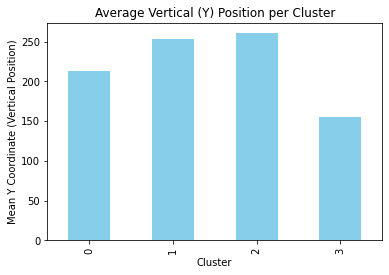

In [159]:
cluster_to_pose = {
    0: 'Standing',
    1: 'Sitting',
    2: 'Lying',
    3: 'Leaning'
}
print("Cluster to Pose Mapping:")
for cluster, pose in cluster_to_pose.items():
    print(f"Cluster {cluster} → Pose: {pose}")

# Calculate mean Y values per cluster for all joints that start with 'Y_'
mean_y_per_cluster = pose_clusters_all.groupby('Cluster').mean(numeric_only=True).filter(like='Y_')

# Calculate overall mean vertical position per cluster (averaging all Y_ joints)
mean_y_per_cluster['Mean_Y'] = mean_y_per_cluster.mean(axis=1)

print("Mean Y coordinate per cluster:")
print(mean_y_per_cluster['Mean_Y'])

# Plot mean Y per cluster
mean_y_per_cluster['Mean_Y'].plot(kind='bar', color='skyblue')
plt.title('Average Vertical (Y) Position per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Y Coordinate (Vertical Position)')
plt.show()
